# <center> Jigsaw Unintended Bias in Toxicity Classification

# 1.0 Problem Description

<b>The Conversation AI team</b> (it was a research initiated by Jigsaw and Google) build a toxicity model, they found that the model incorrectly learned to associate the names of frequently attacked identities with toxicity. So model predicted high toxicity for those comments which contains word like <b>gay, black, muslim, white, lesbian</b> etc, even when comments were not actually toxic (e.g. I am a gay women.). This happened because the dataset was collected from the sources where such words (or identities) are considered as highly offensive. A model is need to be build which can find the toxicity in the comments and minimize the unintended bias with respect to some identities.

- A toxic comment is that comments which are offensive and sometimes they makes some people leave the discussion (on public forums).
- <b>Unintended bias</b> is related to <b>unplanned bias</b> which happend because the data was collected from such sources which considered some words (or identities) very offensive.

>credit: https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview

### 1.1 Objective and Constraint

<b>Objective</b>

- Predicting whether a comment is toxic or not.
- Minimize the unintended bias.

<b>Constraint</b>

- No strict latency requirements

# 2.0 Data

> Disclaimer: The dataset for this competition contains text that may be considered profane, vulgar, or offensive.

### 2.1 Data Overview

<b>Data Files</b>

- Train Data
 - There is only one file for training and there are 45 columns in the train.csv data. But out of these 45 columns only, a few columns are important for this case study.

- Test data
 - Test data (test.csv) has only two columns (id and comment_text).

So we'll be making our model using this common_text feature which will predict the target (whether a comment is toxic or not).

## 2.2 Understanding The Shape of Data

### Importing necessary libraries

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS

/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/sample_submission.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/all_data.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/test_public_expanded.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/test_private_expanded.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/toxicity_individual_annotations.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/train.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/identity_individual_annotations.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/test.csv


# 2.1 Understanding The Shape of Data

In [2]:
# load the data
train = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv')
test = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv')

In [3]:
# First, lets count how much data we have!
train_len, test_len = len(train.index), len(test.index)
print(f'train size: {train_len}, test size: {test_len}')

train size: 1804874, test size: 97320


In [4]:
# Also, lets take a quick look at what we have 
train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [5]:
# Printing the info of all the colums in our training dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 45 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   id                                   int64  
 1   target                               float64
 2   comment_text                         object 
 3   severe_toxicity                      float64
 4   obscene                              float64
 5   identity_attack                      float64
 6   insult                               float64
 7   threat                               float64
 8   asian                                float64
 9   atheist                              float64
 10  bisexual                             float64
 11  black                                float64
 12  buddhist                             float64
 13  christian                            float64
 14  female                               float64
 15  heterosexual                    

In [6]:
# It's always a good idea to count the amount of missing values before diving into any analysis
# Lets also see how many missing values (in percentage) we are dealing with

miss_val_train_df = train.isnull().sum(axis=0) / train_len
miss_val_train_df = miss_val_train_df[miss_val_train_df > 0] * 100
miss_val_train_df

asian                                  77.553558
atheist                                77.553558
bisexual                               77.553558
black                                  77.553558
buddhist                               77.553558
christian                              77.553558
female                                 77.553558
heterosexual                           77.553558
hindu                                  77.553558
homosexual_gay_or_lesbian              77.553558
intellectual_or_learning_disability    77.553558
jewish                                 77.553558
latino                                 77.553558
male                                   77.553558
muslim                                 77.553558
other_disability                       77.553558
other_gender                           77.553558
other_race_or_ethnicity                77.553558
other_religion                         77.553558
other_sexual_orientation               77.553558
physical_disability 

> As we can see from the table above, a large portion of the data is missing the identity tag. However, as the number is the same for the tags, I assume that the data is complete for the part which has identity tags.

<b>Some features might have relations with Toxicity, like capitals letters in the text, punctuations in the texts. Add the new features into the training set.<b/>

In [7]:
train['total_length'] = train['comment_text'].apply(len)
train['capitals'] = train['comment_text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
train['caps_vs_length'] = train.apply(lambda row: float(row['capitals'])/float(row['total_length']),axis=1)
train['num_exclamation_marks'] = train['comment_text'].apply(lambda comment: comment.count('!'))
train['num_question_marks'] = train['comment_text'].apply(lambda comment: comment.count('?'))
train['num_punctuation'] = train['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '.,;:'))
train['num_symbols'] = train['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '*&$%'))
train['num_words'] = train['comment_text'].apply(lambda comment: len(comment.split()))
train['num_unique_words'] = train['comment_text'].apply(lambda comment: len(set(w for w in comment.split())))
train['words_vs_unique'] = train['num_unique_words'] / train['num_words']
train['num_smilies'] = train['comment_text'].apply(lambda comment: sum(comment.count(w) for w in (':-)', ':)', ';-)', ';)')))

In [8]:
features = ('total_length', 'capitals', 'caps_vs_length', 'num_exclamation_marks','num_question_marks', 'num_punctuation', 'num_words', 'num_unique_words','words_vs_unique', 'num_smilies', 'num_symbols')
columns = ('target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'funny', 'wow', 'sad', 'likes', 'disagree', 'sexual_explicit','identity_annotator_count', 'toxicity_annotator_count')
rows = [{c:train[f].corr(train[c]) for c in columns} for f in features]
train_correlations = pd.DataFrame(rows, index=features)

In [9]:
# Let's see the correlations between new features and targets.

train_correlations

,target,severe_toxicity,obscene,identity_attack,insult,threat,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
total_length,0.006444,0.007962,0.009823,0.053430,0.009085,-0.013198,-0.084710,0.002572,-0.019940,0.060639,0.017617,0.019882,0.020840,-0.030894
capitals,0.026120,0.025127,0.027995,0.050489,0.026358,0.000721,-0.039221,0.009687,-0.005448,0.018707,0.003928,0.014144,0.012405,-0.009082
caps_vs_length,-0.005344,0.010594,0.017088,-0.008477,-0.006029,0.000822,0.021263,-0.000603,0.002848,-0.038470,-0.021716,-0.003575,-0.005510,0.015381
num_exclamation_marks,0.055152,0.035388,0.056108,0.017085,0.052533,0.021267,0.007073,0.002225,0.005158,-0.007866,-0.009384,0.019437,0.000869,0.024115
num_question_marks,0.019308,0.011662,0.019233,0.028554,0.014366,-0.000430,-0.009290,0.001263,0.002023,-0.002731,-0.002180,0.015987,0.006305,-0.003307
num_punctuation,0.016974,0.013266,0.017701,0.042990,0.018911,-0.006479,-0.057187,0.001959,-0.016511,0.029581,0.001415,0.018985,0.018050,-0.021231
num_words,0.009579,0.009696,0.014536,0.050527,0.011975,-0.009893,-0.084398,0.002714,-0.019412,0.059481,0.016121,0.021525,0.020595,-0.029856
num_unique_words,0.016702,0.011900,0.017918,0.053659,0.019494,-0.008946,-0.085764,0.003490,-0.018110,0.063874,0.019634,0.022816,0.020787,-0.029814
words_vs_unique,0.001172,-0.005329,-0.003007,-0.048941,0.001135,0.009367,0.079045,-0.004150,0.016223,-0.060162,-0.020712,-0.015748,-0.019749,0.027853
num_smilies,-0.010040,-0.003877,-0.001024,-0.008337,-0.009401,-0.003190,0.010109,-0.002777,-0.002133,-0.016607,-0.010936,-0.000414,-0.000576,-0.003030


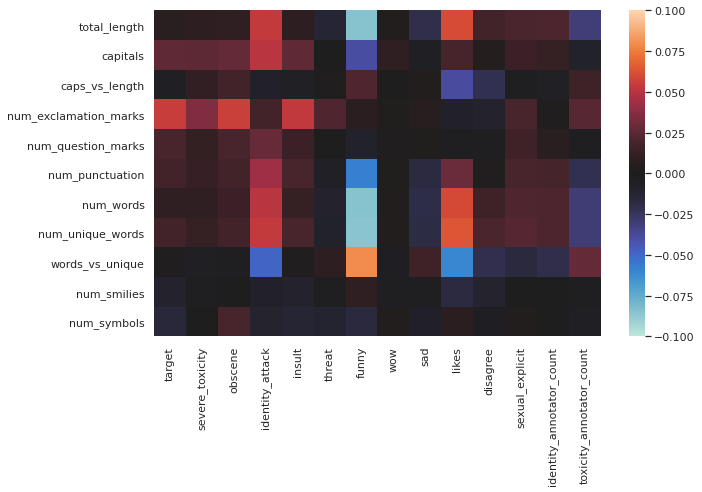

In [10]:
# Correlations between new features and targets in heatmap:

plt.figure(figsize=(10, 6))
sns.set(font_scale=1)
ax = sns.heatmap(train_correlations, vmin=-0.1, vmax=0.1, center=0.0)

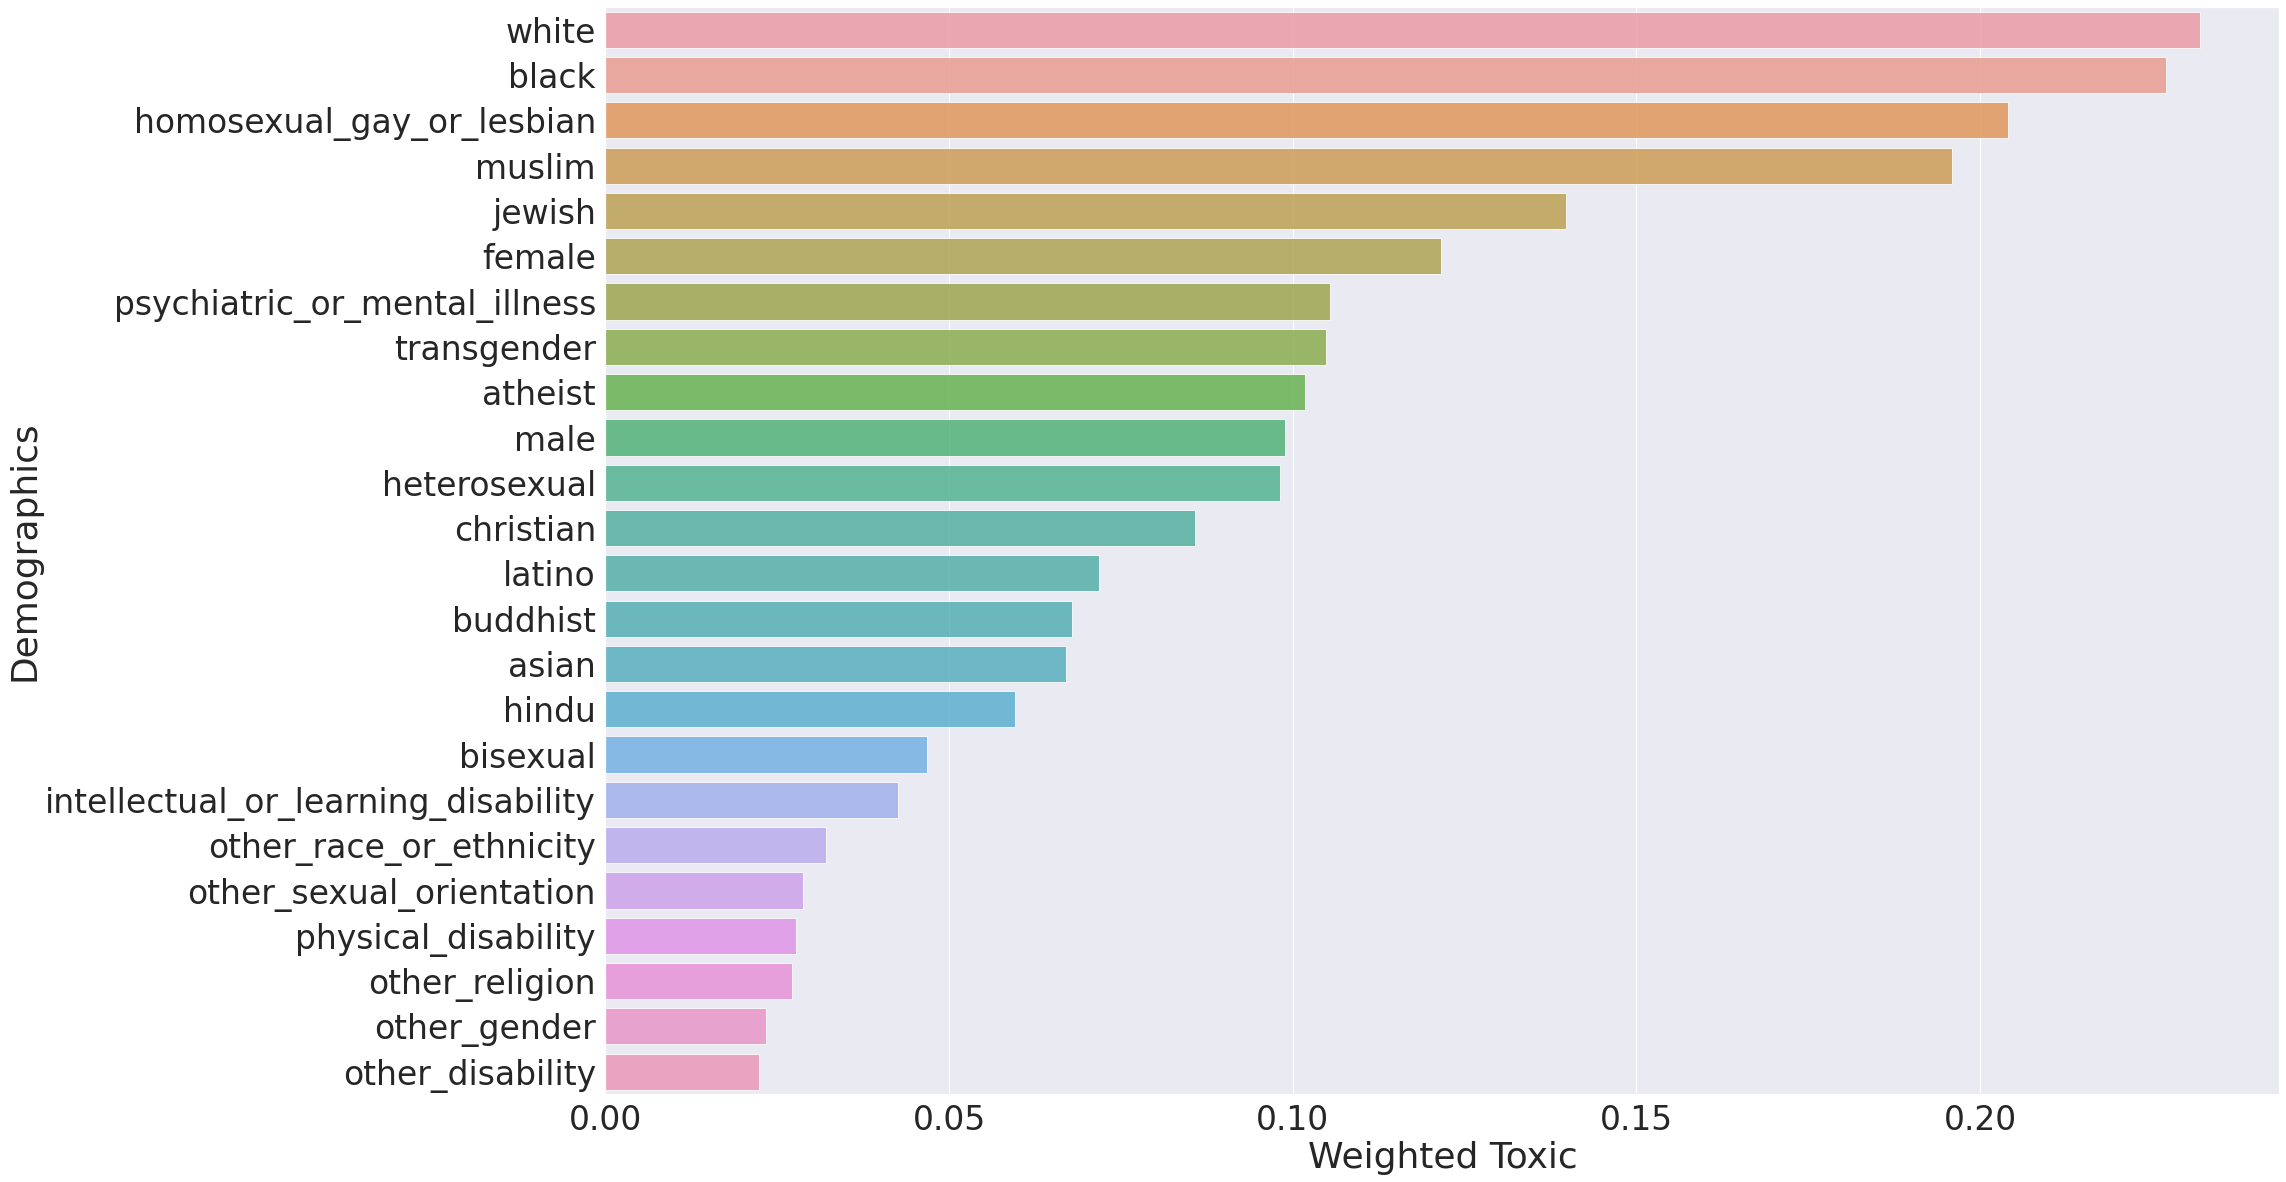

In [11]:
# Percent of toxic comments related to different identities, using target and popolation amount of each identity as weights:

demographics = train.loc[:, ['target']+list(train)[slice(8,32)]].dropna()
weighted_toxic = demographics.iloc[:, 1:].multiply(demographics.iloc[:, 0], axis="index").sum()/demographics.iloc[:, 1:][demographics.iloc[:, 1:]>0].count()
weighted_toxic = weighted_toxic.sort_values(ascending=False)
plt.figure(figsize=(30,20))
sns.set(font_scale=3)
ax = sns.barplot(x = weighted_toxic.values, y = weighted_toxic.index, alpha=0.8)
plt.ylabel('Demographics')
plt.xlabel('Weighted Toxic')
plt.show()

In [12]:
# Meanwhile, we can check the correlations between identities and the comment labels.

identities = tuple(train.iloc[:, 8:32])
rows = [{c:train[f].corr(train[c]) for c in columns} for f in identities]
poptoxicity_correlations = pd.DataFrame(rows, index=identities)

poptoxicity_correlations

,target,severe_toxicity,obscene,identity_attack,insult,threat,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
asian,0.007205,0.005371,-0.004047,0.041203,-0.000664,-0.002817,-0.000409,0.010691,0.001051,-0.003144,0.007868,-0.013710,0.021327,0.001216
atheist,0.010625,0.005047,-0.000122,0.031167,0.005152,0.000781,-0.002847,-0.002600,0.000051,-0.002436,0.001031,-0.004954,0.023635,-0.000433
bisexual,0.021057,0.009279,0.005323,0.047476,0.006283,-0.001796,-0.003230,-0.000367,-0.002987,0.009078,-0.004104,0.024218,0.015360,-0.000380
black,0.167224,0.094418,0.026267,0.314422,0.098186,0.048630,-0.020852,0.001483,0.004480,-0.012769,-0.000631,-0.006407,0.018075,0.035702
buddhist,0.004613,0.004260,-0.001751,0.024143,-0.002909,0.002542,-0.002802,-0.001222,-0.001348,-0.000621,-0.001719,-0.004397,0.010600,-0.002119
christian,-0.006776,-0.000874,-0.025650,0.093885,-0.030669,-0.014324,-0.008460,-0.013146,-0.015212,0.021608,-0.020644,0.008710,0.018038,-0.015846
female,0.062904,0.032653,0.036250,0.052299,0.037995,0.023384,-0.012743,0.008052,0.005052,0.036137,0.008464,0.153735,0.009830,0.007588
heterosexual,0.038193,0.018239,0.008396,0.073282,0.012613,-0.003600,-0.002225,-0.001381,-0.001339,0.006148,-0.002821,0.066624,0.010674,0.003018
hindu,0.003607,0.003839,-0.002221,0.022695,-0.001895,0.001549,-0.002369,-0.000161,-0.001025,0.002924,0.002689,-0.005251,0.014825,-0.001248
homosexual_gay_or_lesbian,0.131110,0.064122,0.026097,0.249880,0.061920,0.016785,-0.003616,-0.001935,0.003452,0.012015,-0.002378,0.099424,0.020577,0.019139


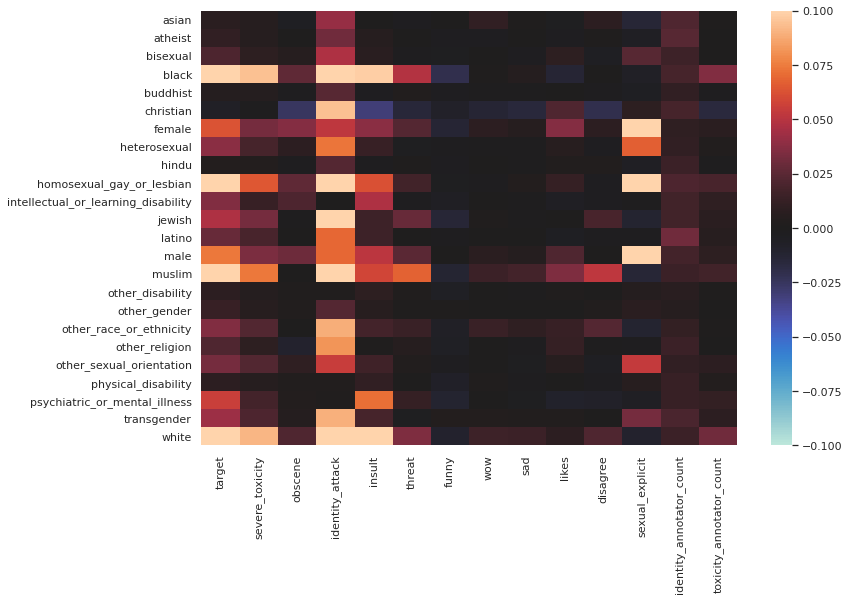

In [13]:
# Heatmap for the correlations

plt.figure(figsize=(12, 8))
sns.set(font_scale=1)
ax = sns.heatmap(poptoxicity_correlations, vmin=-0.1, vmax=0.1, center=0.0)

In [14]:
import gc

del train_correlations
del poptoxicity_correlations

gc.collect()

13435

# 3.0 Time Series Analysis of Comments Made

In [15]:
# Lets again create a list of all the identities tagged in this dataset. This list given in the data section of this competition. 

identities_all = ['male','female','transgender','other_gender','heterosexual','homosexual_gay_or_lesbian',
              'bisexual','other_sexual_orientation','christian','jewish','muslim','hindu','buddhist',
              'atheist','other_religion','black','white','asian','latino','other_race_or_ethnicity',
              'physical_disability','intellectual_or_learning_disability','psychiatric_or_mental_illness',
              'other_disability']

# Now getting the dataframe with identities tagged
#train_labeled_df = train.loc[:, ['target'] + identities_all].dropna()

In [16]:
# We can also check the Time Series for Toxicity with different identities:
withdate = train.loc[:, ['created_date', 'target'] + identities_all].dropna()
raceweighted = withdate.iloc[:, 2:]/withdate.iloc[:, 2:].sum()
race_target_weighted = raceweighted.multiply(withdate.iloc[:, 1], axis="index")
race_target_weighted['comment_count'] = 1
# now we add the date to our newly created dataframe (also parse the text date as datetime)
race_target_weighted['created_date'] = pd.to_datetime(withdate['created_date']).values.astype('datetime64[M]')
weighted_demo = race_target_weighted.groupby(['created_date']).sum().sort_index()

In [17]:
pip install chart_studio

     |████████████████████████████████| 64 kB 1.8 MB/s 
Note: you may need to restart the kernel to use updated packages.


In [18]:
# Importing plotly credentials for time series datavisualizations

import plotly
import chart_studio
import chart_studio.plotly as py
import cufflinks as cf
import plotly.graph_objs as go
chart_studio.tools.set_credentials_file(username='raisul_bd', api_key='gkmwlmRYR0UBe11MnK4O')
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [19]:
weighted_demo[['white', 'asian', 'black', 'jewish', 'latino', 'other_race_or_ethnicity']].iplot(title = 'Time Series Toxicity & Race', filename='Time Series Toxicity & Race' )

# Click on the legend to change display. Double click for single identity.

> <b>Here we see the relative weighted toxic score for each identity of races for two year span.<b/>

In [20]:
weighted_demo[['atheist', 'buddhist', 'christian', 'hindu', 'muslim', 'other_religion']].iplot(title = 'Time Series Toxicity & Religion', filename='Time Series Toxicity & Religion')

# Click on the legend to change display. Double click for single identity.

> <b>Here we see the relative weighted toxic score for each identity of Religion for two year span.<b/>

In [21]:
weighted_demo[['heterosexual', 'homosexual_gay_or_lesbian', 'bisexual', 'other_sexual_orientation']].iplot(title = 'Time Series Toxicity & Sexual Orientation', filename='Time Series Toxicity & Sexual Orientation')

# Click on the legend to change display. Double click for single identity.

> <b>Here we see the relative weighted toxic score for each identity of Sexual Orientation for two year span.<b/>

In [22]:
weighted_demo[['male', 'female', 'transgender', 'other_gender']].iplot(title = 'Time Series Toxicity & Gender', filename='Time Series Toxicity & Gender')

# Click on the legend to change display. Double click for single identity.

> <b>Here we see the relative weighted toxic score for each identity of Gender for two year span. It's clearly visible that the Toxicity level for Transgenders is significantly higher than the other Genders.<b/>

In [23]:
weighted_demo[['physical_disability', 'intellectual_or_learning_disability', 'psychiatric_or_mental_illness', 'other_disability']].iplot(title = 'Time Series Toxicity & Disability', filename='Time Series Toxicity & Disability')

# Click on the legend to change display. Double click for single identity.

> <b>Here we see the relative weighted toxic score for each identity of Disability for two year span.<b/>

# 4.0 Zooming Into the Peaks

> #### Observation: After plotting these charts, we have found that most data have a peak around Jan 2017. A bit curious. Let's check what's different between Jan 2017 and other time.

In [24]:
alldate_toxicity = train[train['target'] >= 0.5].loc[:, ['created_date', 'target', 'comment_text']].dropna()
alldate_toxicity['created_date'] = pd.to_datetime(alldate_toxicity['created_date']).values.astype('datetime64[M]')
jan_2017_toxicity = alldate_toxicity[alldate_toxicity['created_date'] == '2017-01-01']

from nltk.corpus import stopwords
def check_frequency(data = alldate_toxicity['comment_text'], n = 20):
    stop = stopwords.words('english')
    data  = data.apply(lambda x: " ".join(x.lower() for x in x.split()))
    data = data.str.replace('[^\w\s]','')
    data = data.apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    freq = pd.Series(' '.join(data).split()).value_counts()[:n]
    return freq

top_10_toxicity_othertime = check_frequency(data = alldate_toxicity[alldate_toxicity['created_date'] != '2017-01-01']['comment_text'], n = 10)
top_10_toxicity_jan_2017 = check_frequency(data = jan_2017_toxicity['comment_text'], n = 10)

Let's check, which toxicity related word appears Top 10 in jan_2017, but not in other time Top 10.

In [25]:
top_10_toxicity_jan_2017.index.difference(top_10_toxicity_othertime.index)

Index([], dtype='object')

Apparently, none of them. All the same. Then let's theck their frequency.

In [26]:
percent_toxicity_othertime = top_10_toxicity_othertime/alldate_toxicity[alldate_toxicity['created_date'] != '2017-01-01']['comment_text'].str.split().str.len().sum()
percent_toxicity_jan_2017 = top_10_toxicity_jan_2017/jan_2017_toxicity['comment_text'].str.split().str.len().sum()
top_toxicity = pd.concat([percent_toxicity_jan_2017, percent_toxicity_othertime], axis=1, sort=False)
top_toxicity.columns = ['Jan_2017', 'Other_Time']
top_toxicity['Difference'] = top_toxicity['Jan_2017'] - top_toxicity['Other_Time']

In [27]:
top_toxicity.head(30)

,Jan_2017,Other_Time,Difference
trump,0.005175,0.004231,0.000943
people,0.003828,0.004018,-0.000191
like,0.003643,0.003650,-0.000007
dont,0.002613,0.002662,-0.000049
one,0.002587,0.002684,-0.000097
would,0.002556,0.002828,-0.000271
us,0.002512,0.001903,0.000609
get,0.002296,0.002427,-0.000131
stupid,0.001985,0.002072,-0.000087
think,0.001680,0.001696,-0.000017


Lets Plot the values to see the frequency over words.

In [28]:
import chart_studio.plotly as py
import plotly.graph_objects as go

trace1 = go.Bar(
    x=top_toxicity.index,
    y=top_toxicity['Jan_2017'],
    name='Jan_2017'
)
trace2 = go.Bar(
    x=top_toxicity.index,
    y=top_toxicity['Other_Time'],
    name='Other_Time'
)

data = [trace2, trace1]
layout = go.Layout(
    barmode='group'
)
layout = go.Layout(yaxis=dict(tickformat=".2%"))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, title = 'Top Toxicity Comarision', filename='top_toxicity_comarision')

In [29]:
# After checking the whole time series, let's see that, which Time of the day People are more Toxic.

train['datetime64'] = pd.to_datetime(train['created_date']).values.astype('datetime64[h]')
train['hour'] = train['datetime64'].dt.hour
all_comments_by_hour = train['target'].groupby(train['hour']).sum().sort_index()/train['target'].groupby(train['hour']).sum().sum()
toxic_comments_by_hour = train[train['target'] >= 0.5]['target'].groupby(train['hour']).sum().sort_index()/train[train['target'] >= 0.5]['target'].groupby(train['hour']).sum().sum()
comments_hour_check = pd.concat([all_comments_by_hour, toxic_comments_by_hour], axis=1, sort=False)
comments_hour_check.columns = ['all_comments', 'toxic_comments']

In [30]:
labels = ['Midnight', 'Morning', 'Noon', 'Evening', 'Midnight']
tickvals = ['0', '6', '12', '18', comments_hour_check.index.max()]

trace1 = go.Scatter(
    x=comments_hour_check.index,
    y=comments_hour_check['all_comments'],
    name = 'comment percent per H',
    line = dict(
        color = ('rgb(22, 96, 167)'),
        width = 1)
)
trace2 = go.Scatter(
    x=comments_hour_check.index,
    y=comments_hour_check['toxic_comments'],
    name = 'toxic comment percent per H',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 1,)
)

trace3 = go.Bar(
    x=comments_hour_check.index,
    y=comments_hour_check['toxic_comments']-comments_hour_check['all_comments'],
    name = 'More Toxic Comment Ratio'
)

data = [trace1, trace2, trace3]

layout = go.Layout(yaxis=dict(tickformat=".2%"),
                   title = 'Which Time are People More Toxic',
                   xaxis=go.layout.XAxis(
                       ticktext=labels, 
                       tickvals=tickvals
                   ),
                  )
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='Which Time are People More Toxic')

#### Interestingly, this shows Evening is the most busy part of the day when people uses Toxic words.

# 5.0 Scatter Plots for a given identity

Since there are so many spikes in our dataset, it is very easy to get distracted. To have a better idea we must zoom out. In this section we do that by extracting the peaks. This could be challenging, as we are not just looking for one global maximum. On the other hand, even if we sort it, we will not be able to find all the relative maximums without writing a complex algorithm to do so.

Fortunately, there is a great algorithm from scipy library called 'argrelextrema' that will allow us to extract the relative maximum points from our dataset. 

For more details about this algorithm, check out the document section: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.argrelextrema.html

In [31]:
# Lets import the algorithm
from scipy.signal import argrelextrema

Using this algorithm, we want to create a pandas dataframe to capture all the extreme points in our dataset that captures all the peak points per identity group. We will also want to do a scatter plot in the next section, and scatterplot implementation needs both values (x and y) to be numeric. So we also better create a column to represent the dates in a more numeric form.

We can do this by taking the date of the first comment as our reference point, and counting how many days the comment was made from the first comment in our dataset. Therefore, in the end we should get a dataframe with the following columns:

| identity | created data | score | days_from_first |

In [32]:
# lets group most of the identities into three major categories as follows for simplified analysis

races = ['black','white','asian','latino','other_race_or_ethnicity']
religions = ['atheist', 'buddhist', 'christian', 'hindu', 'muslim', 'jewish','other_religion']
sexual_orientation = ['heterosexual', 'homosexual_gay_or_lesbian', 'bisexual', 'other_sexual_orientation']

In [33]:
# we will store all the different datapoints in the following dataframe
peaks_df = pd.DataFrame()

# first we loop through all the different identities we are interested in
for col in races + religions + sexual_orientation:
    # we pass the values through the algorithm to get an index of the rel. maximums 
    _max_index = argrelextrema(weighted_demo[col].values, np.greater, order=15)
    # we use the index returned to create a dataframe of the values for those index. in this case 
    # we are interested in the created date and the score, notice how the dataframe needs to be 
    # transformed because of the orientation of the arrays we started off with
    col_peaks_df = pd.DataFrame(data = [weighted_demo.index[_max_index], weighted_demo[col].values[_max_index]]).T
    col_peaks_df.columns = ['created_date','score']
    # we create a new column labeling the identity so we can track which peak came from which identity
    col_peaks_df['identity'] = col
    # and we keep appending to our main dataframe 
    peaks_df = peaks_df.append(col_peaks_df)

# lets set identity as our index and we are done
peaks_df = peaks_df.set_index('identity')

In [34]:
# lets create a list of all the identities tagged in this dataset. This list given in the data section of this competition. 

identities = ['male','female','transgender','other_gender','heterosexual','homosexual_gay_or_lesbian',
              'bisexual','other_sexual_orientation','christian','jewish','muslim','hindu','buddhist',
              'atheist','other_religion','black','white','asian','latino','other_race_or_ethnicity',
              'physical_disability','intellectual_or_learning_disability','psychiatric_or_mental_illness',
              'other_disability']

In [35]:
# To count the number of days from the first comment, we take our labeled data and convert the created date column

comments_with_date_df = train.loc[:, ['created_date', 'target','comment_text'] + identities].dropna()
comments_with_date_df['created_date'] = pd.to_datetime(withdate['created_date'].apply(lambda dt: dt[:10]))
comments_with_date_df['comment_count'] = 1

In [36]:
# calculate days from first comment

first_dt = min(comments_with_date_df['created_date'].values)
last_dt = max(comments_with_date_df['created_date'].values)
peaks_df['days_from_first'] = (peaks_df['created_date'] - first_dt).dt.days

In [37]:
# Here is a peak at what our peaks_df looks like
peaks_df.head()

,created_date,score,days_from_first
identity,,,
black,2017-09-01,0.0473693,703
white,2017-08-01,0.0639786,672
asian,2017-08-01,0.0166209,672
latino,2017-08-01,0.0244604,672
other_race_or_ethnicity,2017-08-01,0.0200895,672


Now that we have the peaks, lets visualize it. Scatter plot is typically used to show if there is a correlation between two variables. However, in this case, we can also use scatterplot to draw the relative maximums as descrete points. The nice thing about a scatter plot is that we can visualize a third variable as the size of the point. Let's take advantage of this and use the number of comments made as the size of the relative maximum points.

In [38]:
# lets create a function that returns the peaks dataframe for a given identity
# we also want to get the number of toxic comments made against that identity in the dataframe

def get_identity_peaks_df(identity, peaks_df, comments_with_date_df):
    # select subset and sort
    identity_peaks_df = peaks_df[peaks_df.index==identity].sort_values(by='score', ascending=False)
    # change the score type to float
    identity_peaks_df['score'] = identity_peaks_df.score.astype(float)
    # use created date as the index so we can join over in later step
    identity_peaks_df = identity_peaks_df.set_index('created_date')
    # calculate how many toxic comments were made targetting the given identity group
    identity_comment_count_df = comments_with_date_df[comments_with_date_df[identity] > 0][['created_date','comment_count']].groupby('created_date').sum()
    # do an inner join to also get the total number of comments made that day for the given identity
    identity_peaks_df = identity_peaks_df.join(identity_comment_count_df)
    return identity_peaks_df

In [39]:
# To make our scatter plot more presentable we will set the max and min of our y axis
y_lim_min = peaks_df['score'].max() + peaks_df['score'].max() / 3 # adding a little bit head room on y axis
y_lim_max = peaks_df['score'].min()

In [40]:
# now lets write a function that draws the scatter plot for a given identity

def identity_scatter_plot(identity, identity_peaks_df, y_lim_min, y_lim_max):
    x = identity_peaks_df['days_from_first'].values
    y = identity_peaks_df['score'].values
    size = identity_peaks_df['comment_count'].values
    label = identity_peaks_df['comment_count'].index
    plt.figure(figsize=(15,7))
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.scatter(x, y, s=size, label=label)
    plt.ylim(y_lim_max, y_lim_min)
    axis_font = {'fontname':'Arial', 'size':'14'}
    plt.title('Relative Maximums - Targeted Against '+ identity.capitalize() +' Identity', fontsize=15)
    plt.xlabel('Comment Date', fontsize=15)
    plt.ylabel('Relative Weighted Toxic Score', fontsize=15)

Now we are ready to plot each relative maximums per identity group. However, lets only look at top 5 for now. If you remember the horizontal bar plot we did at the start of our tutorial (second graph from the top), you can see that the identities that are most frequently targeted are white, black, homosexual_gay_or_lesbian, muslim, and jewish.

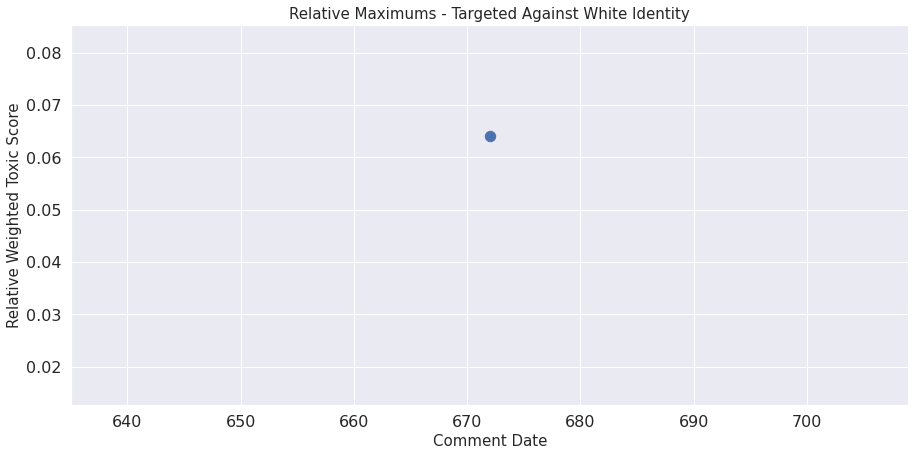

In [41]:
identity = 'white'
identity_peaks_df = get_identity_peaks_df(identity, peaks_df, comments_with_date_df)
identity_scatter_plot(identity, identity_peaks_df, y_lim_min, y_lim_max)

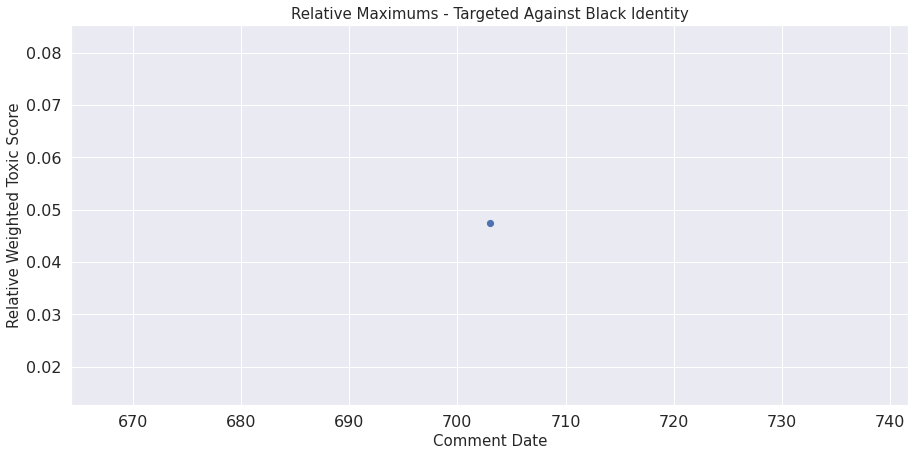

In [42]:
identity = 'black'
identity_peaks_df = get_identity_peaks_df(identity, peaks_df, comments_with_date_df)
identity_scatter_plot(identity, identity_peaks_df, y_lim_min, y_lim_max)

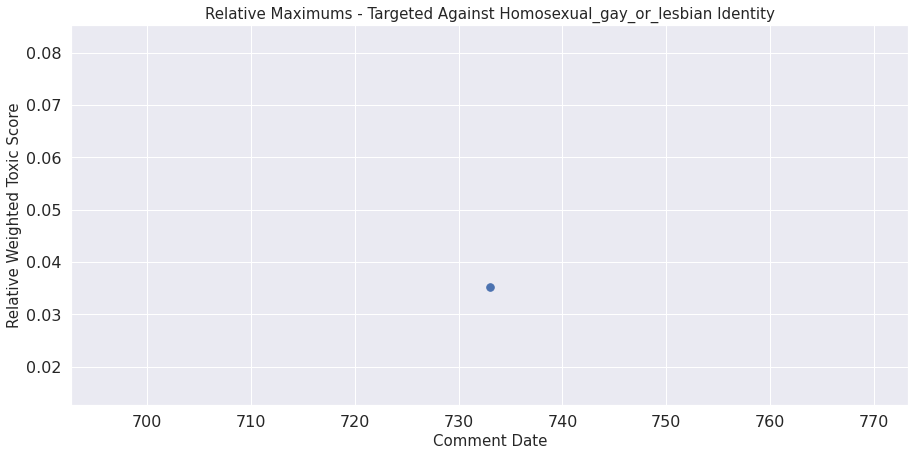

In [43]:
identity = 'homosexual_gay_or_lesbian'
identity_peaks_df = get_identity_peaks_df(identity, peaks_df, comments_with_date_df)
identity_scatter_plot(identity, identity_peaks_df, y_lim_min, y_lim_max)

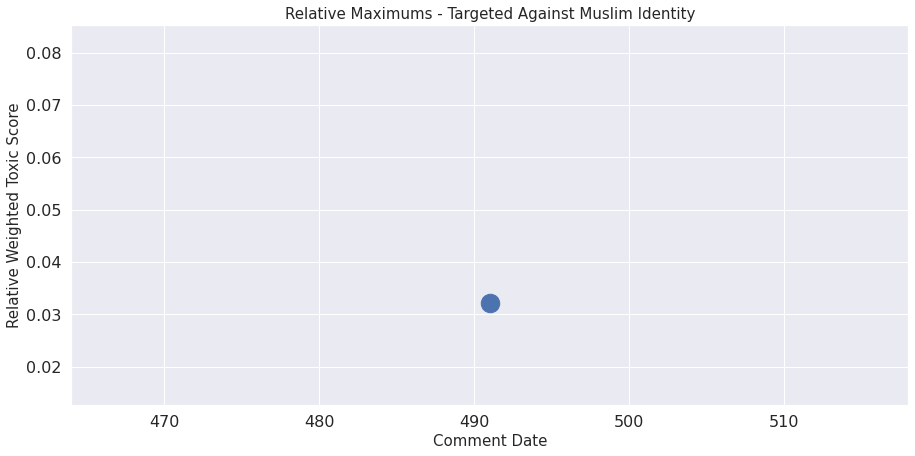

In [44]:
identity = 'muslim'
identity_peaks_df = get_identity_peaks_df(identity, peaks_df, comments_with_date_df)
identity_scatter_plot(identity, identity_peaks_df, y_lim_min, y_lim_max)

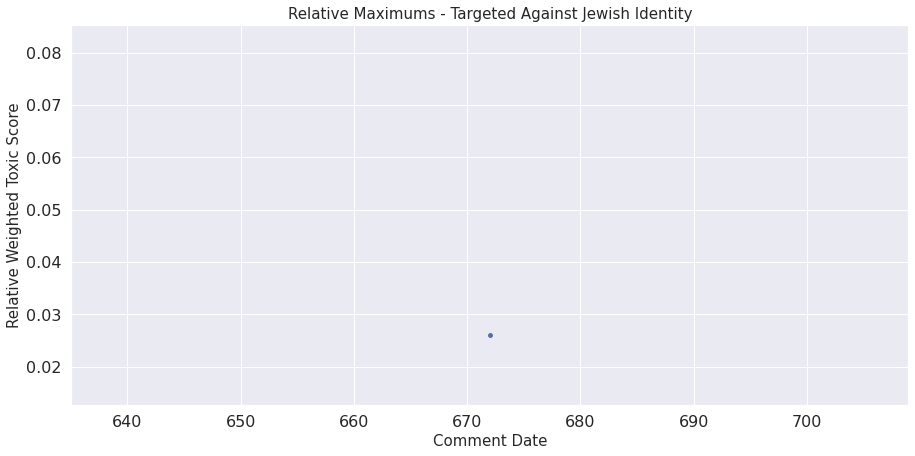

In [45]:
identity = 'jewish'
identity_peaks_df = get_identity_peaks_df(identity, peaks_df, comments_with_date_df)
identity_scatter_plot(identity, identity_peaks_df, y_lim_min, y_lim_max)

# 5.1 Correlation and Heatmap of Identities

To better understand the dataset, we need to look at the correlation between each identities. Thus, in this section we will calculate the correlation between each of the identities and see if identities are often mentioned together. We are also interested to know which identities are frequently mentioned (or not mentioned) together. Understanding correlation for a large number of columns would be very difficult without visualization. However, this task is very simple once we draw a heatmap.

<AxesSubplot:>

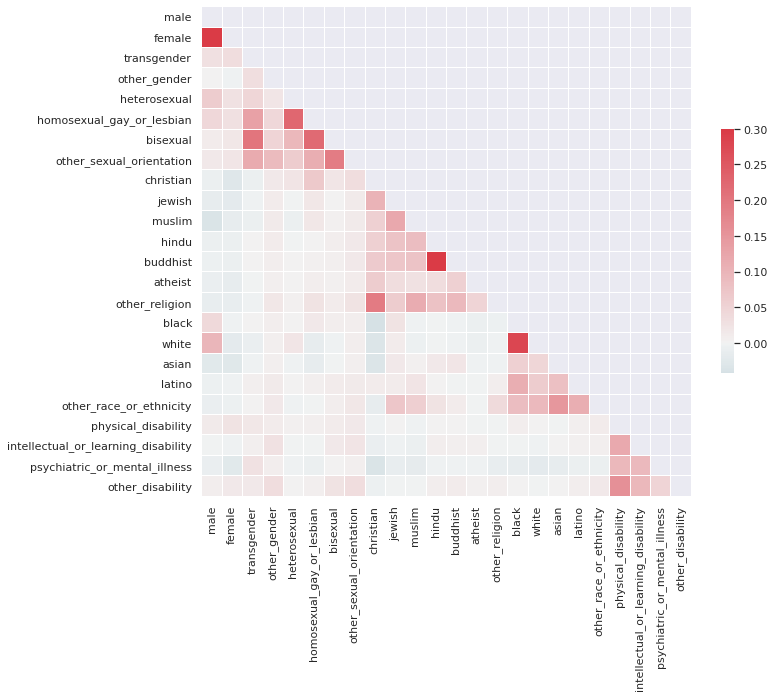

In [46]:
# Lets import seaborn
import seaborn as sns

# Compute the correlation matrix
corr = comments_with_date_df[identities].corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
sns.set(font_scale = 1)
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

The heatmap plot of the correlation between the identities is very insightful. I will summarize my observations below.

- It is interesting to see that strong correlations form triangular area at the edge of diagonal.
- This basically means that there is a strong correlation between the groups of the identity (gender, religion, races, disabilities). This means, the comments where male identity is the target, female identity is also very likely to be the target.
- In another words, in toxic and non-toxic comments, people tend to make it about one group vs another quiet frequently.

# 6.0 Generating Word Clouds

Tag cloud or word cloud is an effective way to visualize text data. Also, to clear the clutter and focus better, I will only use the comments from the peaks per identity and create word cloud of the most frequent words. To do this we will use a popular python library called WordCloud. We will also use NLTK to take stop words (like the, it, and so on) out of our WordCloud.

Reference: https://www.datacamp.com/community/tutorials/wordcloud-python

In [47]:
# Import wordcloud
from wordcloud import WordCloud
# import NLTK mainly for stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [48]:
# We will write a simple function to generate the wordcloud per identity group

def generate_word_cloud(identity, toxic_comments, non_toxic_comments):
    # convert stop words to sets as required by the wordcloud library
    stop_words = set(stopwords.words("english"))
    # create toxic wordcloud
    wordcloud_toxic = WordCloud(max_font_size=100, max_words=100, background_color="white", stopwords=stop_words).generate(toxic_comments)
    # create non-toxic wordcloud
    wordcloud_non_toxic = WordCloud(max_font_size=100, max_words=100, background_color="white", stopwords=stop_words).generate(non_toxic_comments)
    # draw the two wordclouds side by side using subplot
    fig = plt.figure(figsize=[15,5])
    fig.add_subplot(1, 2, 1).set_title("Toxic Wordcloud", fontsize=10)
    plt.imshow(wordcloud_toxic, interpolation="bilinear")
    plt.axis("off")
    fig.add_subplot(1, 2, 2).set_title("Non Toxic Wordcloud", fontsize=10)
    plt.imshow(wordcloud_non_toxic, interpolation="bilinear")
    plt.axis("off")
    plt.subplots_adjust(top=0.85)
    plt.suptitle('Word Cloud - {} Identity'.format(identity), size = 16)
    plt.show()

In [49]:
# This function returns a tuple (toxic comments, non toxic comments) for the peaks

def get_comments(identity, identity_peaks_df):
    # create an empty array to return comments
    toxic_comments, non_toxic_comments = np.array([]), np.array([])
    # go over all the dates and grab the relevant comments for the given identity
    for dt in identity_peaks_df.index:
        # get the toxic comments
        comments_dt_df = comments_with_date_df[(comments_with_date_df['created_date'] == dt) \
                                               & (comments_with_date_df[identity] > 0) \
                                               & (comments_with_date_df['target'] >= .5)]
        toxic_comments = np.append(toxic_comments, comments_dt_df['comment_text'].values)
        
        # get the non toxic comments
        comments_dt_df = comments_with_date_df[(comments_with_date_df['created_date'] == dt) \
                                               & (comments_with_date_df[identity] > 0) \
                                               & (comments_with_date_df['target'] < .5)]
        non_toxic_comments = np.append(non_toxic_comments, comments_dt_df['comment_text'].values)
    
    return (toxic_comments, non_toxic_comments)

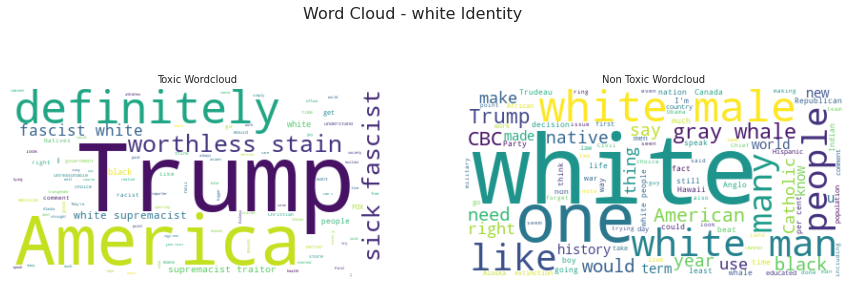

In [50]:
# lets draw the wordcloud for white identity

identity = 'white'
# get the peaks for the given identity
identity_peaks_df = get_identity_peaks_df(identity, peaks_df, comments_with_date_df)
# get the comments for the given identity for the peaks
identity_comments = get_comments(identity, identity_peaks_df)
# lets convert the comments as one long string (as needed by wordcloud)
toxic_comments = ' '.join(identity_comments[0])
non_toxic_comments = ' '.join(identity_comments[1])
# draw the wordcloud using the function we created earlier
generate_word_cloud(identity, toxic_comments, non_toxic_comments)

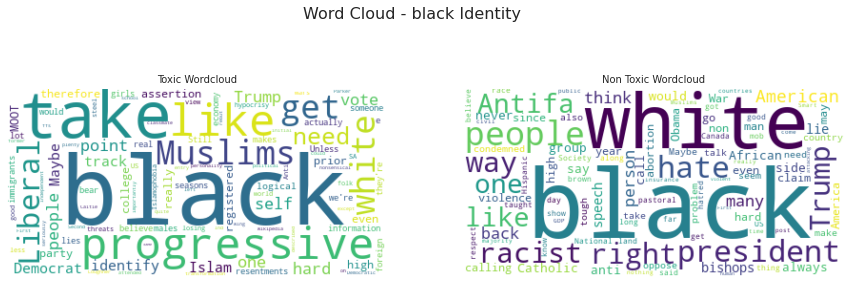

In [51]:
# Like white identity, lets draw the wordcloud for the other top identities

identity = 'black'
identity_peaks_df = get_identity_peaks_df(identity, peaks_df, comments_with_date_df)
identity_comments = get_comments(identity, identity_peaks_df)
toxic_comments = ' '.join(identity_comments[0])
non_toxic_comments = ' '.join(identity_comments[1])
generate_word_cloud(identity, toxic_comments, non_toxic_comments)

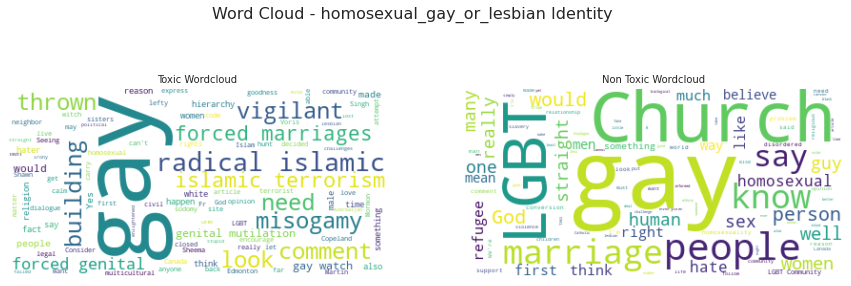

In [52]:
identity = 'homosexual_gay_or_lesbian'
identity_peaks_df = get_identity_peaks_df(identity, peaks_df, comments_with_date_df)
identity_comments = get_comments(identity, identity_peaks_df)
toxic_comments = ' '.join(identity_comments[0])
non_toxic_comments = ' '.join(identity_comments[1])
generate_word_cloud(identity, toxic_comments, non_toxic_comments)

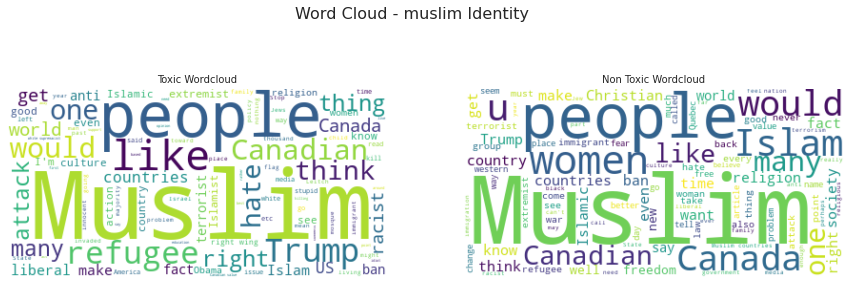

In [53]:
identity = 'muslim'
identity_peaks_df = get_identity_peaks_df(identity, peaks_df, comments_with_date_df)
identity_comments = get_comments(identity, identity_peaks_df)
toxic_comments = ' '.join(identity_comments[0])
non_toxic_comments = ' '.join(identity_comments[1])
generate_word_cloud(identity, toxic_comments, non_toxic_comments)


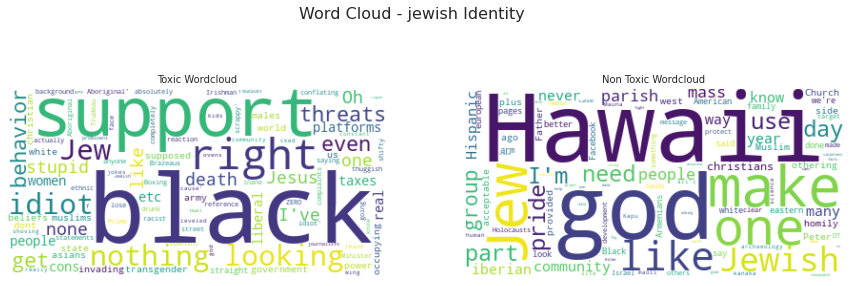

In [54]:
identity = 'jewish'
identity_peaks_df = get_identity_peaks_df(identity, peaks_df, comments_with_date_df)
identity_comments = get_comments(identity, identity_peaks_df)
toxic_comments = ' '.join(identity_comments[0])
non_toxic_comments = ' '.join(identity_comments[1])
generate_word_cloud(identity, toxic_comments, non_toxic_comments)

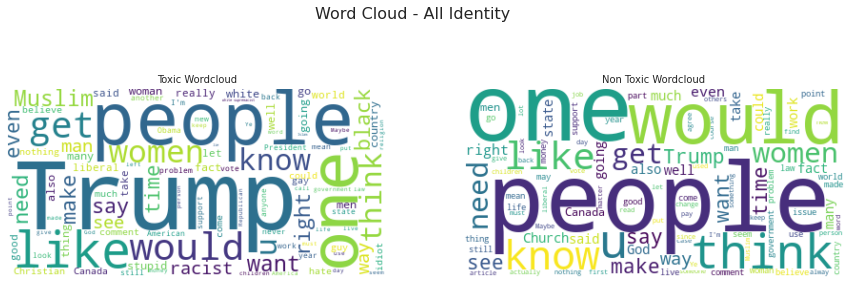

In [55]:
toxic_comments = comments_with_date_df[comments_with_date_df['target'] >= .5]['comment_text'].values
non_toxic_comments = comments_with_date_df[comments_with_date_df['target'] < .5]['comment_text'].values
toxic_comments = ' '.join(toxic_comments)
non_toxic_comments = ' '.join(non_toxic_comments)
generate_word_cloud('All', toxic_comments, non_toxic_comments)

The wordcloud above is really interesting. Looking at it, I have made the following observations:

Although the sentiment within the sentences (probably) varies in toxic and non-toxic comments, looking at it from top word frequencies, the differences are not that big.
Between comments about White and Black identity, there is a huge overlap!
Comments towards homosexual have more unique set of words (as imagined) from the other identity groups. However, between toxic and non-toxic comment there isn't a big variation in terms of the high frequenty words.
For comments about Jewish identity, the word Muslim appears frequently. After reviewing a lot of the samples of such comments I noticed that a large number of comments about Jewish identity is toxic towards Muslim identity.
Ironically, Trump is a very frequent common topic of discussion in toxic and non-toxic comments. However, frequency of Trump appearing is more in toxic comments. "Trump" or "Trump Supporters" could be a identitity in itself =)